In [185]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest
import matplotlib.pyplot as plt

# Load Data

In [188]:
with open('12_23_18_data.pkl','rb') as f:
    updates,starting_time,K,starting_book,starting_ref_price = pickle.load(f)
len(updates)

10798

# Combine Updates that Occur At Same Time

In [94]:
grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
# Contains dictionary of time, reference price, order book, list of changes
cleaned_updates = []
for t, us in grouped_by_time.items():
    if len(us) == 1:
        u = us[0]
        cleaned_updates.append(copy.copy(u))
    else:
        new_update = {'time': t}
        us = sorted(us, key=lambda u:-abs(u['k']))
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
        reference_k = list(grouped_by_k.keys())[0]
        new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
        new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
        events = []
        for k in grouped_by_k:
            combined_change = 0
            for u in grouped_by_k[k]:
                combined_change = combined_change + u['change']
            events.append((k,combined_change))
        for k,change in events:
            new_update = copy.deepcopy(new_update)
            new_update['k'] = k
            new_update['change'] = change
            cleaned_updates.append(new_update)

cleaned_updates
len(cleaned_updates)

10642

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [95]:
combined_updates = []
i = 0
while i < len(cleaned_updates):
    reference_price = cleaned_updates[i]['reference_price']
    j = i
    updates_at_reference = []
    while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
        updates_at_reference.append(cleaned_updates[j])
        j += 1
    updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
    grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
    for k,us in grouped_by_k.items():
        us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
        keep_index = [True for u in us]
        for m in reversed(range(1,len(us))):
            quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
            same_sign = (us[m]['change'] * us[m-1]['change']) > 0
            if quick_same_order and same_sign:
                us[m-1]['change'] += us[m]['change']
                keep_index[m] = False
        for (u,keep) in zip(us, keep_index):
            if keep:
                combined_updates.append(u)
    i = j + 1
    
combined_updates = sorted(combined_updates,key=lambda u:u['time'])
len(combined_updates)

10223

# Calculate Average Event Size at Each Position

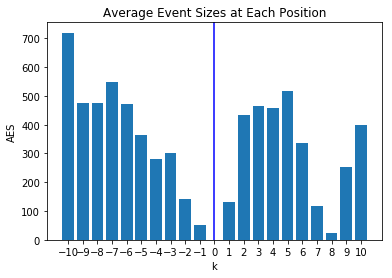

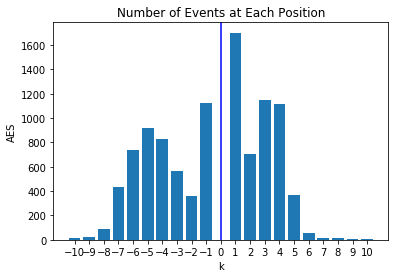

In [96]:
# Get Average Event Sizes
event_sizes = OrderedDict([(i,[]) for i in range(-K,K+1) if i != 0])
for update in combined_updates:
    event_sizes[update['k']].append(abs(update['change']))
AESs = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
numbers_of_events = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for (k,event_sizes) in event_sizes.items():
    AESs[k] = np.mean(event_sizes)
    numbers_of_events[k] = len(event_sizes)
    
k,AES = zip(*AESs.items())
        
b1 = plt.bar(k, AES)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Average Event Sizes at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

k,number_of_events = zip(*numbers_of_events.items())
b1 = plt.bar(k, number_of_events)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Number of Events at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

# Get time between events at each position and queue size

In [146]:
def transform_book(book):
    res = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    for k,actual_size in book.items():
        if math.isnan(AESs[k]):
            size = 1
        else:
            size = int(actual_size / AESs[k])
        res[k] = size
    return res

# Get times between events
maximum_sizes = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for update in combined_updates:
    transformed_book = transform_book(update['LOB'])
    for k,size in transformed_book.items():
        if size > maximum_sizes[k]:
            maximum_sizes[k] = size
            
time_between_events_pos = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])
time_between_events_neg = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])

for k in range(-K,K+1):
    if k != 0:
        for i in range(maximum_sizes[k] + 1):
            time_between_events_pos[k][i] = []
        for i in range(1,maximum_sizes[k] + 1):
            time_between_events_neg[k][i] = []           
                
t = starting_time
reference_change_time = t
last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
old_reference_price = starting_ref_price

for update in combined_updates:
    reference_price = update['reference_price']
    transformed_book = transform_book(update['LOB'])
    t = update['time']
    if reference_price != old_reference_price:
        last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
        reference_change_time = t
        old_reference_price = reference_price

    k = update['k']
    time_between_change = (t-last_change_time_at_k[k]).total_seconds()
    size = transformed_book[k]
    if update['change'] > 0:
        time_between_events_pos[k][size].append(time_between_change)
        last_change_time_at_k[k]= t
    else:
        if size > 0:
            time_between_events_neg[k][size].append(time_between_change)
            last_change_time_at_k[k] = t 

# QQ Plots of Times Between Events Compared to Exponential Distribution

k = -8, size = 0
Number of positive jump times: 33
Mean: 5.671181818181818


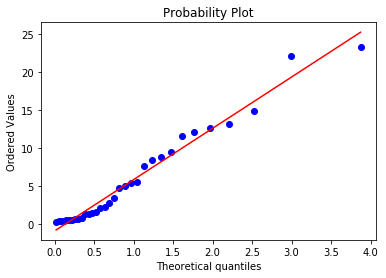



k = -7, size = 0
Number of positive jump times: 107
Mean: 5.149532710280375


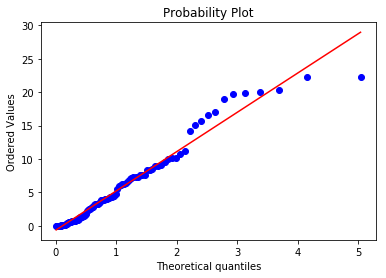



k = -7, size = 11
Number of positive jump times: 46
Mean: 0.03908695652173913


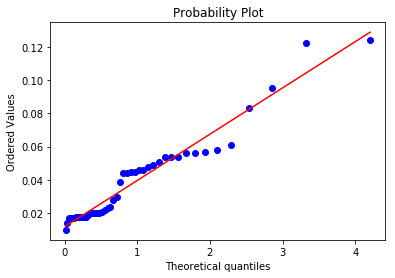



k = -6, size = 0
Number of positive jump times: 144
Mean: 0.5990208333333334


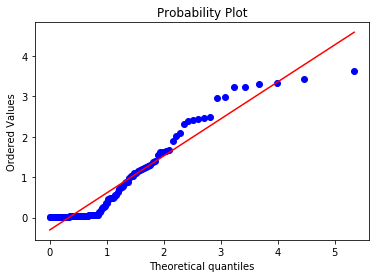



k = -6, size = 1
Number of positive jump times: 45
Mean: 2.187866666666667


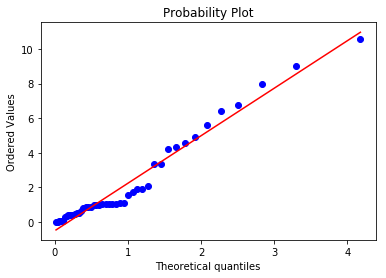



k = -6, size = 10
Number of positive jump times: 34
Mean: 0.033911764705882357


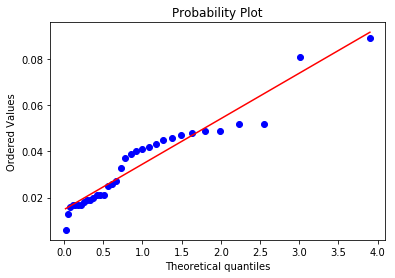



k = -6, size = 11
Number of positive jump times: 29
Mean: 1.8231724137931034


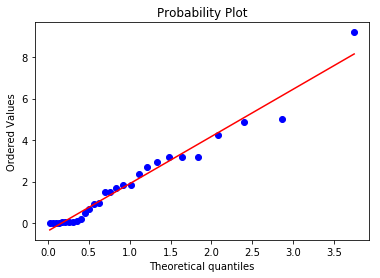



k = -6, size = 13
Number of positive jump times: 25
Mean: 0.03672


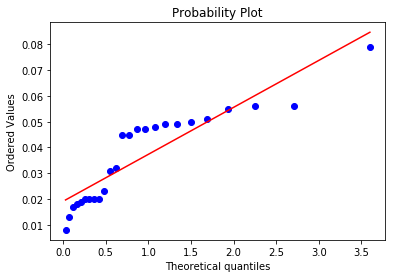



k = -5, size = 0
Number of positive jump times: 58
Mean: 1.2160172413793104


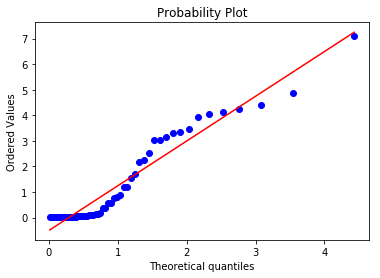



k = -5, size = 1
Number of positive jump times: 80
Mean: 1.0420625


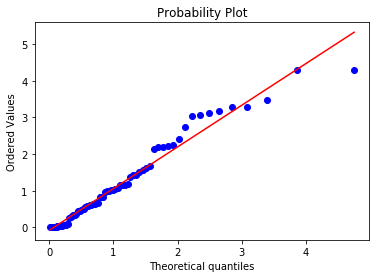



k = -5, size = 2
Number of positive jump times: 71
Mean: 0.6713380281690141


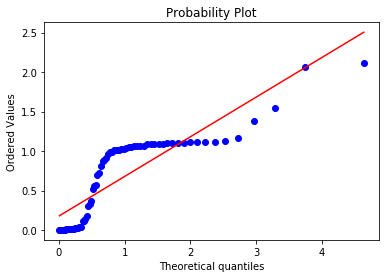



k = -5, size = 3
Number of positive jump times: 87
Mean: 0.3834597701149426


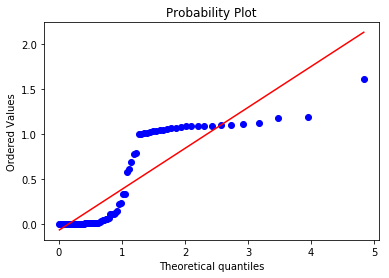



k = -5, size = 4
Number of positive jump times: 33
Mean: 0.9049696969696971


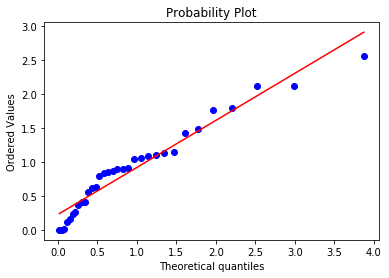



k = -5, size = 14
Number of positive jump times: 45
Mean: 1.6976000000000004


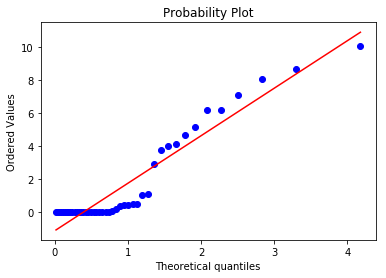



k = -4, size = 2
Number of positive jump times: 47
Mean: 0.5216808510638298


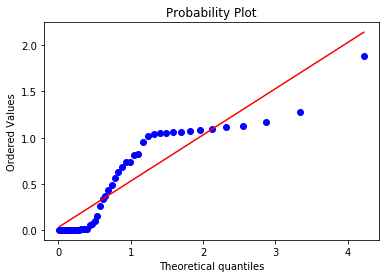



k = -4, size = 3
Number of positive jump times: 76
Mean: 0.506421052631579


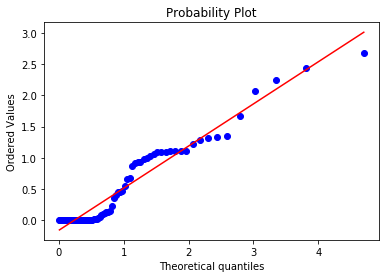



k = -4, size = 4
Number of positive jump times: 43
Mean: 0.48067441860465115


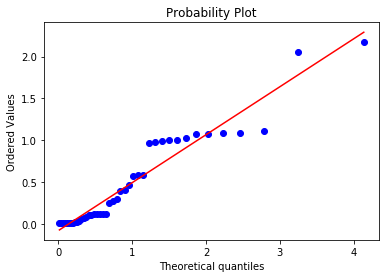



k = -4, size = 5
Number of positive jump times: 80
Mean: 0.6676249999999999


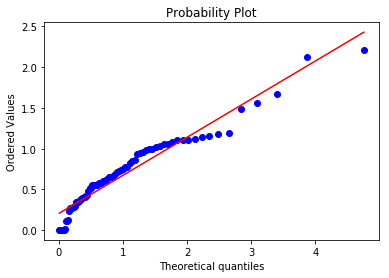



k = -4, size = 6
Number of positive jump times: 29
Mean: 0.6545517241379311


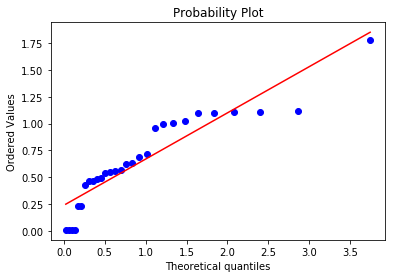



k = -4, size = 7
Number of positive jump times: 22
Mean: 1.042318181818182


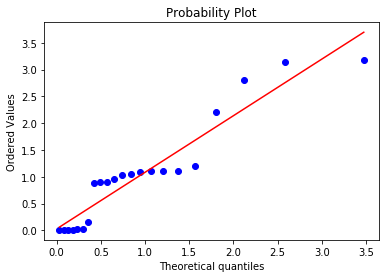



k = -4, size = 21
Number of positive jump times: 24
Mean: 0.77075


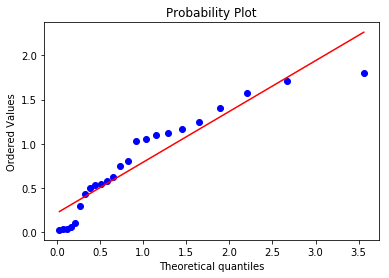



k = -3, size = 0
Number of positive jump times: 25
Mean: 0.83184


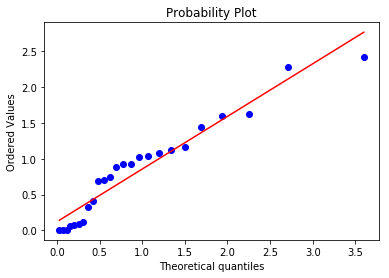



k = -3, size = 1
Number of positive jump times: 87
Mean: 0.5646091954022989


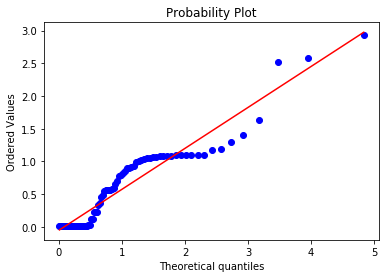



k = -3, size = 2
Number of positive jump times: 64
Mean: 0.5421562500000001


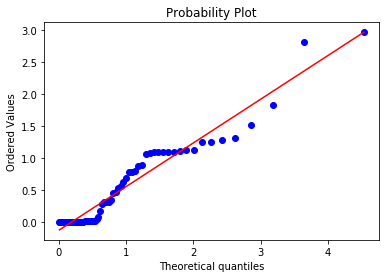



k = -3, size = 3
Number of positive jump times: 35
Mean: 0.7897142857142858


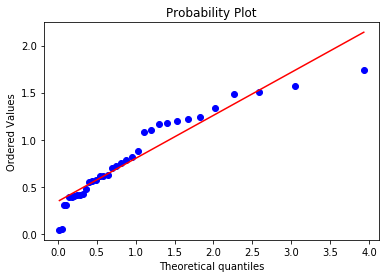



k = -2, size = 2
Number of positive jump times: 33
Mean: 9.566666666666666


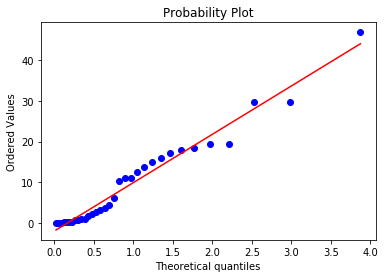



k = -2, size = 7
Number of positive jump times: 29
Mean: 3.419758620689655


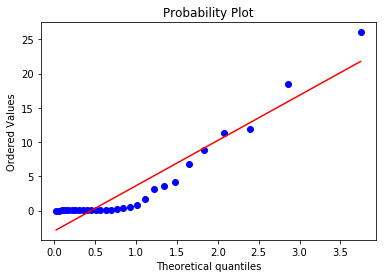



k = -1, size = 0
Number of positive jump times: 24
Mean: 10.197166666666666


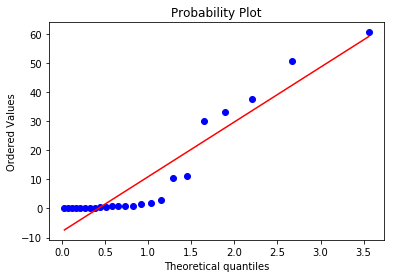



k = -1, size = 1
Number of positive jump times: 31
Mean: 0.7438709677419355


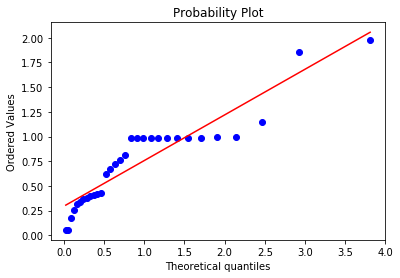



k = -1, size = 2
Number of positive jump times: 74
Mean: 0.8753378378378377


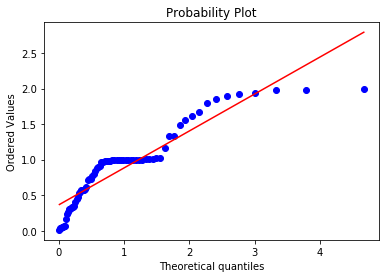



k = -1, size = 3
Number of positive jump times: 51
Mean: 0.7568823529411765


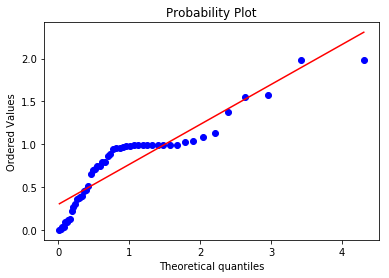



k = -1, size = 4
Number of positive jump times: 91
Mean: 0.9088131868131869


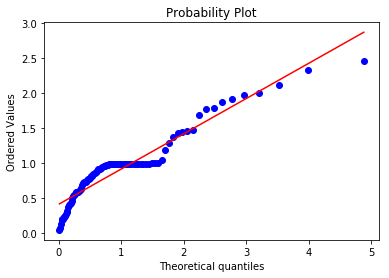



k = -1, size = 5
Number of positive jump times: 44
Mean: 0.9541818181818182


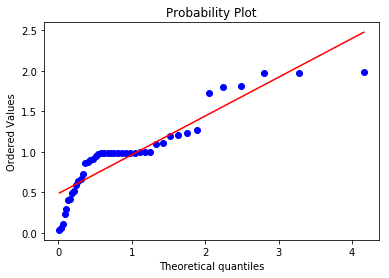



k = -1, size = 6
Number of positive jump times: 27
Mean: 0.7068148148148148


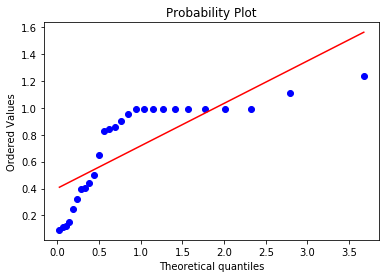



k = -1, size = 7
Number of positive jump times: 26
Mean: 0.8150384615384615


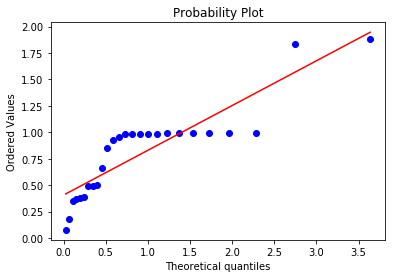



k = 1, size = 0
Number of positive jump times: 117
Mean: 1.2181025641025638


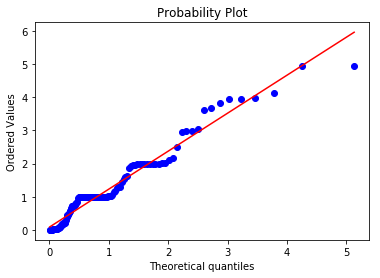



k = 1, size = 1
Number of positive jump times: 230
Mean: 0.7882260869565217


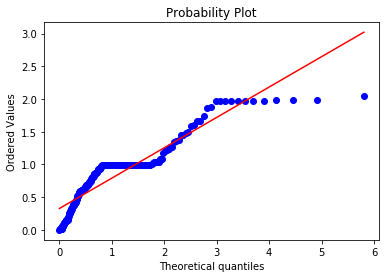



k = 1, size = 2
Number of positive jump times: 117
Mean: 1.1155897435897433


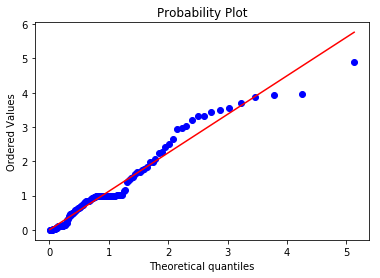



k = 1, size = 3
Number of positive jump times: 45
Mean: 1.0779333333333332


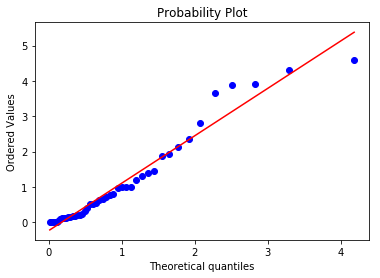



k = 1, size = 5
Number of positive jump times: 58
Mean: 4.544620689655173


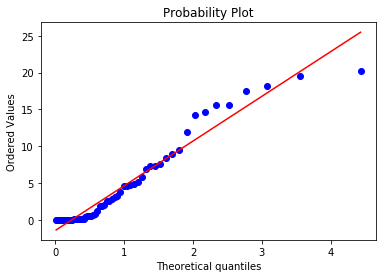



k = 1, size = 6
Number of positive jump times: 48
Mean: 2.1486666666666667


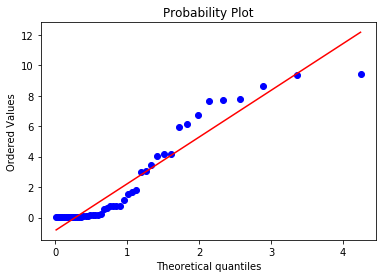



k = 1, size = 7
Number of positive jump times: 63
Mean: 2.2627142857142863


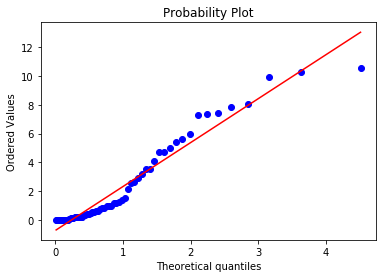



k = 2, size = 0
Number of positive jump times: 34
Mean: 1.1525588235294117


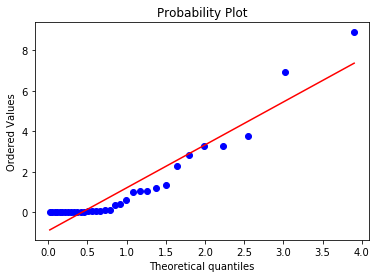



k = 2, size = 1
Number of positive jump times: 86
Mean: 1.3688604651162792


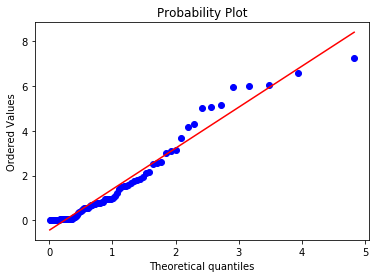



k = 2, size = 2
Number of positive jump times: 99
Mean: 0.2916868686868687


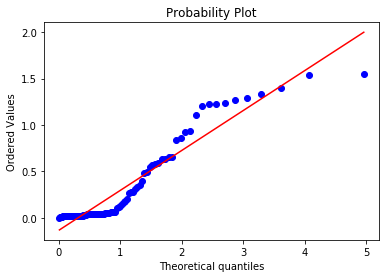



k = 2, size = 3
Number of positive jump times: 25
Mean: 4.08588


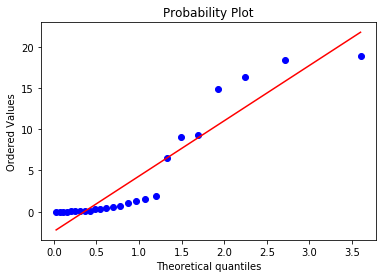



k = 3, size = 0
Number of positive jump times: 87
Mean: 0.034540229885057463


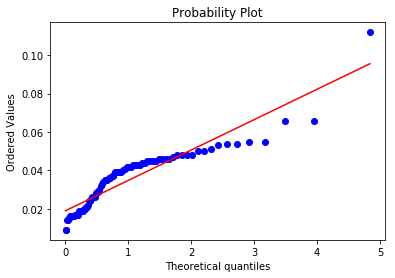



k = 3, size = 1
Number of positive jump times: 188
Mean: 0.256


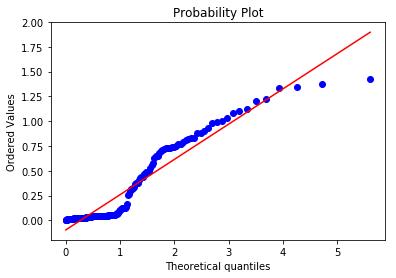



k = 3, size = 2
Number of positive jump times: 38
Mean: 0.6700000000000002


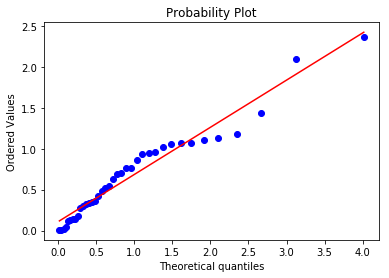



k = 3, size = 11
Number of positive jump times: 84
Mean: 0.03322619047619048


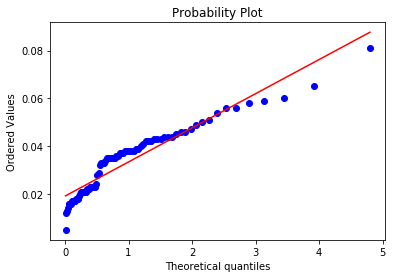



k = 3, size = 12
Number of positive jump times: 61
Mean: 0.4847868852459016


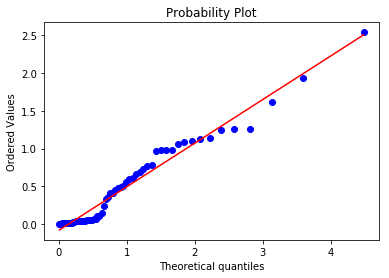



k = 4, size = 0
Number of positive jump times: 85
Mean: 1.2598


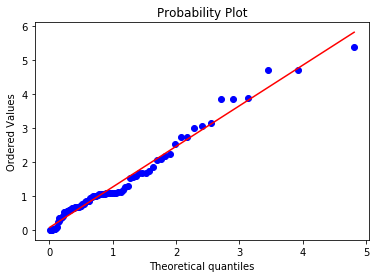



k = 4, size = 1
Number of positive jump times: 158
Mean: 0.5585506329113924


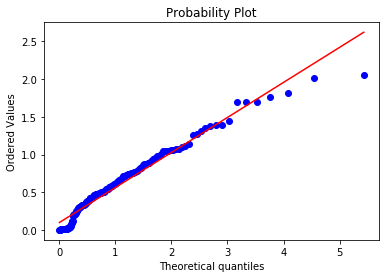



k = 4, size = 2
Number of positive jump times: 25
Mean: 0.42672


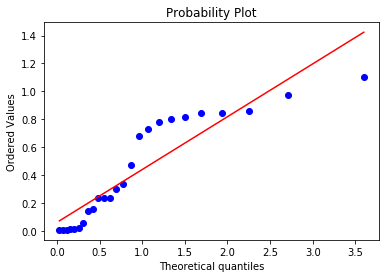



k = 4, size = 10
Number of positive jump times: 43
Mean: 6.32206976744186


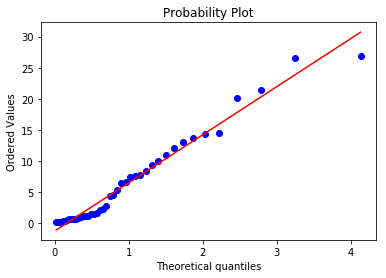



k = 4, size = 11
Number of positive jump times: 66
Mean: 0.5129696969696969


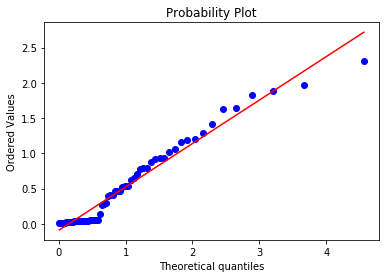



k = 4, size = 12
Number of positive jump times: 63
Mean: 0.6821428571428572


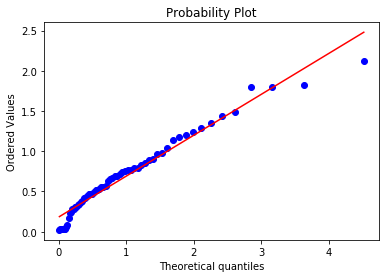



k = 5, size = 0
Number of positive jump times: 67
Mean: 1.5351940298507465


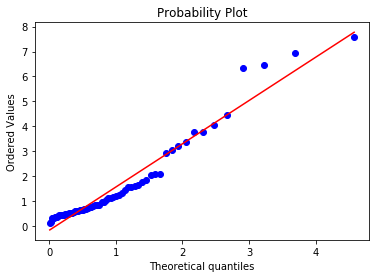



k = 5, size = 1
Number of positive jump times: 21
Mean: 0.6153333333333334


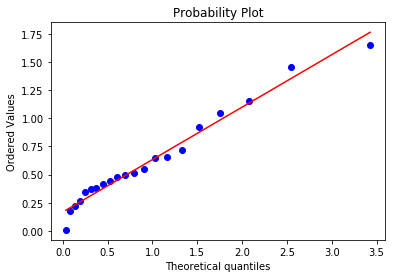



k = 5, size = 9
Number of positive jump times: 39
Mean: 0.8554615384615385


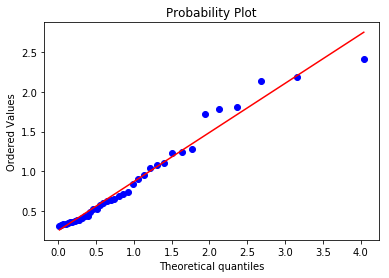



k = -8, size = 1
Number of negative jump times: 31
Mean: 1.6569677419354838


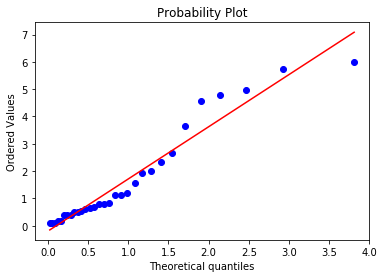



k = -7, size = 1
Number of negative jump times: 99
Mean: 3.968969696969697


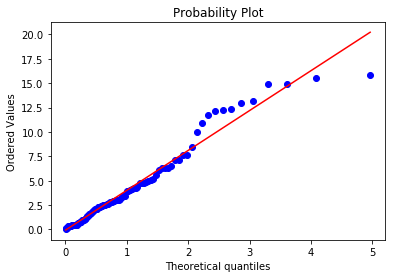



k = -7, size = 12
Number of negative jump times: 52
Mean: 3.6314807692307696


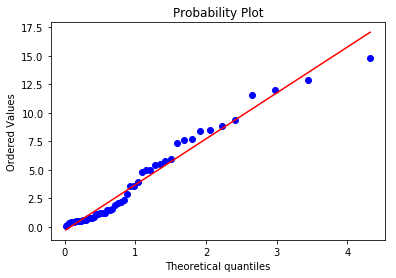



k = -6, size = 1
Number of negative jump times: 156
Mean: 4.296326923076923


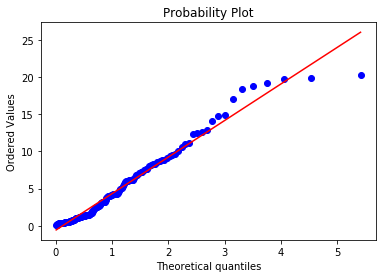



k = -6, size = 2
Number of negative jump times: 31
Mean: 1.8389032258064515


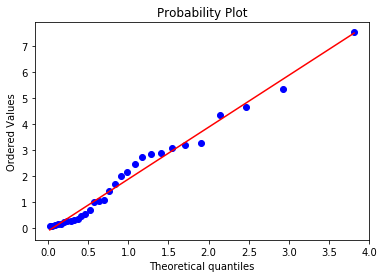



k = -6, size = 11
Number of negative jump times: 31
Mean: 3.24341935483871


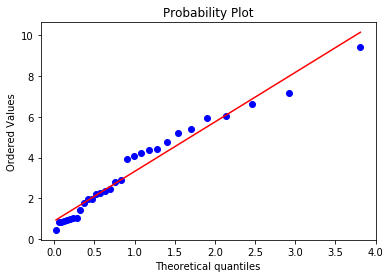



k = -6, size = 12
Number of negative jump times: 35
Mean: 4.031028571428572


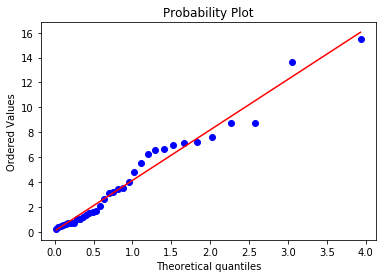



k = -6, size = 14
Number of negative jump times: 27
Mean: 6.363074074074075


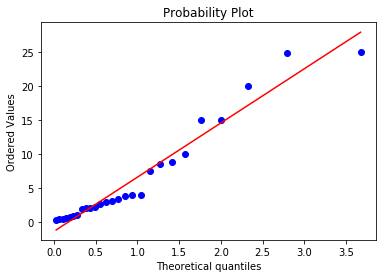



k = -5, size = 1
Number of negative jump times: 27
Mean: 3.2105925925925924


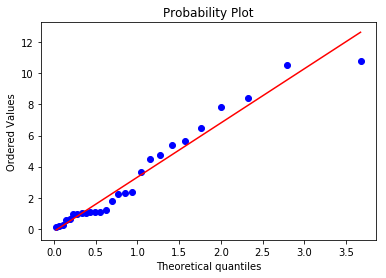



k = -5, size = 2
Number of negative jump times: 84
Mean: 1.174345238095238


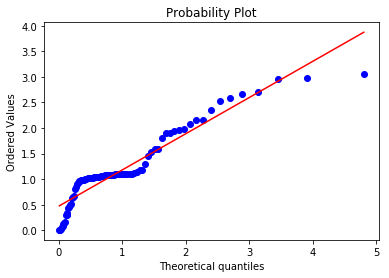



k = -5, size = 3
Number of negative jump times: 106
Mean: 0.9297075471698113


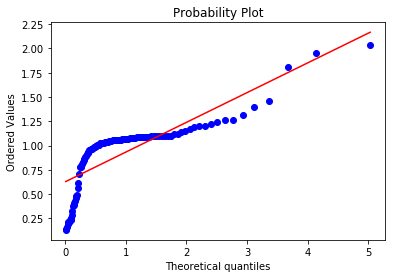



k = -5, size = 4
Number of negative jump times: 21
Mean: 0.897


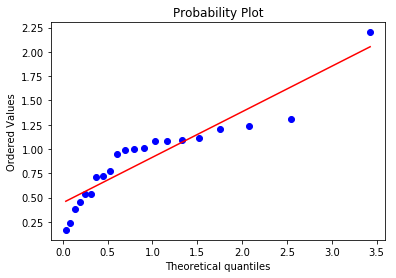



k = -5, size = 15
Number of negative jump times: 54
Mean: 7.10722362962963


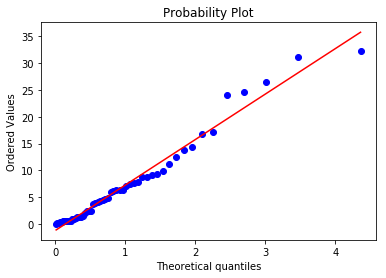



k = -4, size = 2
Number of negative jump times: 28
Mean: 0.8572500000000002


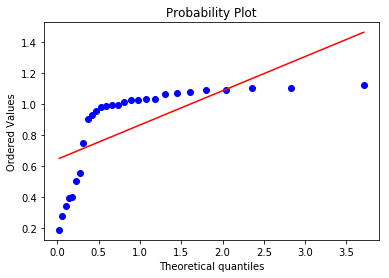



k = -4, size = 3
Number of negative jump times: 33
Mean: 1.0624848484848486


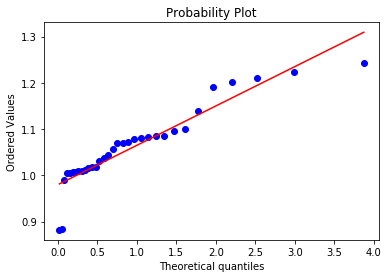



k = -4, size = 4
Number of negative jump times: 37
Mean: 0.8822432432432432


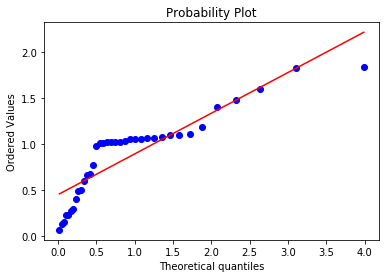



k = -4, size = 5
Number of negative jump times: 45
Mean: 0.8155333333333334


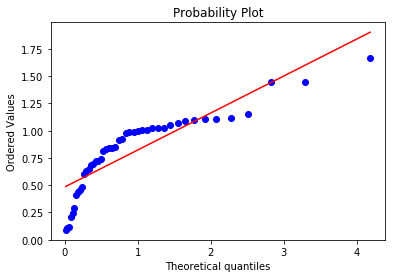



k = -4, size = 6
Number of negative jump times: 46
Mean: 0.9652173913043477


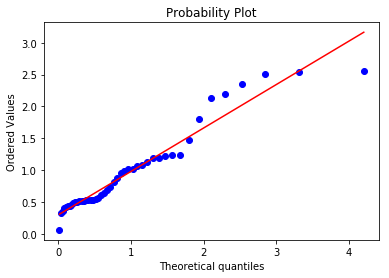



k = -4, size = 7
Number of negative jump times: 62
Mean: 0.6830322580645164


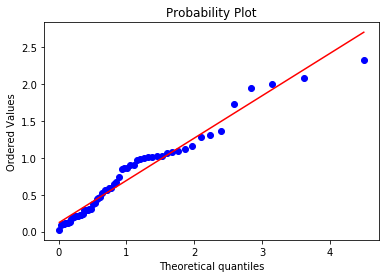



k = -4, size = 23
Number of negative jump times: 21
Mean: 0.577952380952381


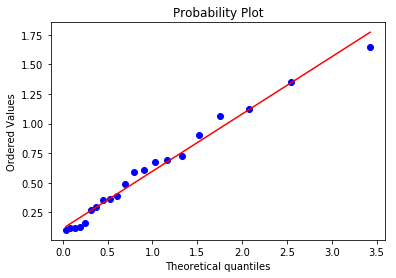



k = -3, size = 1
Number of negative jump times: 37
Mean: 1.0485945945945947


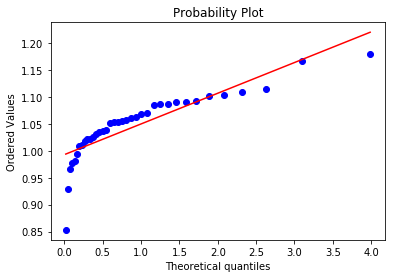



k = -3, size = 2
Number of negative jump times: 66
Mean: 0.8503484848484848


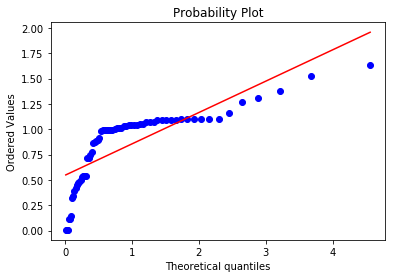



k = -3, size = 3
Number of negative jump times: 42
Mean: 0.887452380952381


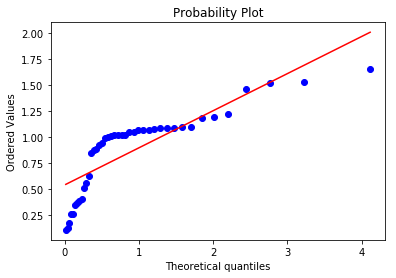



k = -3, size = 4
Number of negative jump times: 38
Mean: 0.3921315789473684


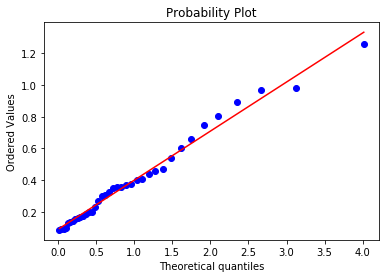



k = -2, size = 3
Number of negative jump times: 39
Mean: 9.153307692307694


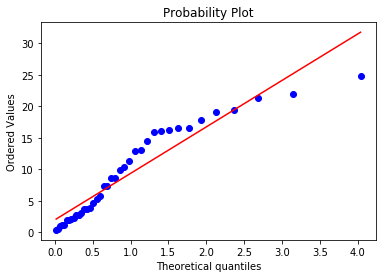



k = -2, size = 7
Number of negative jump times: 23
Mean: 7.114826086956521


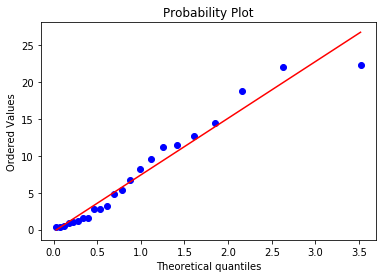



k = -1, size = 2
Number of negative jump times: 51
Mean: 0.5706666666666665


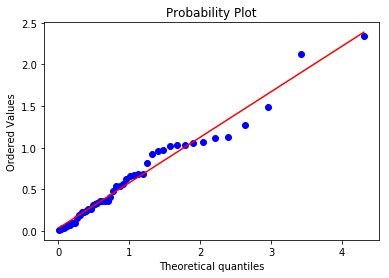



k = -1, size = 3
Number of negative jump times: 55
Mean: 0.6708181818181816


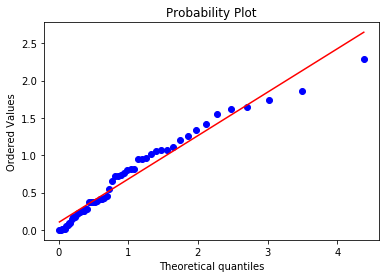



k = -1, size = 4
Number of negative jump times: 107
Mean: 0.5272710280373831


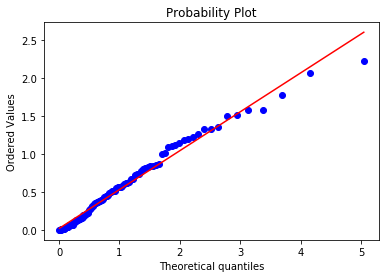



k = -1, size = 5
Number of negative jump times: 52
Mean: 0.6433653846153847


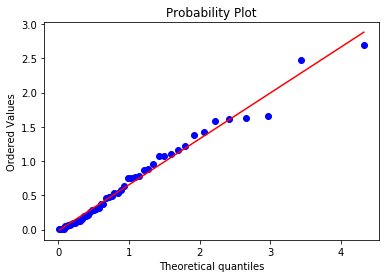



k = -1, size = 6
Number of negative jump times: 30
Mean: 0.4171333333333333


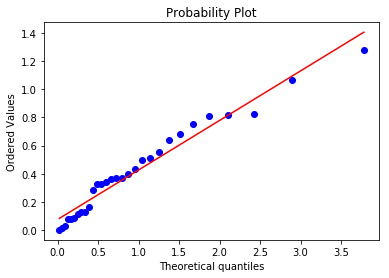



k = -1, size = 7
Number of negative jump times: 33
Mean: 0.6944242424242423


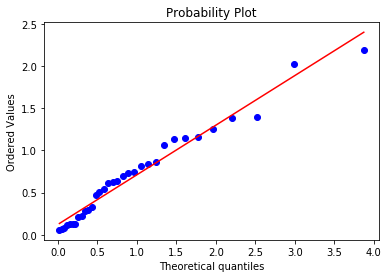



k = -1, size = 9
Number of negative jump times: 24
Mean: 21.06791666666667


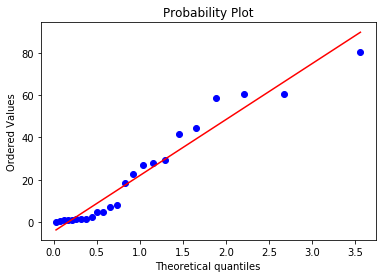



k = 1, size = 1
Number of negative jump times: 141
Mean: 0.5646666666666667


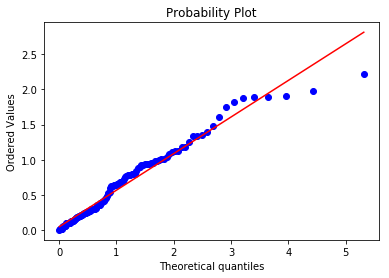



k = 1, size = 2
Number of negative jump times: 132
Mean: 1.620932393939394


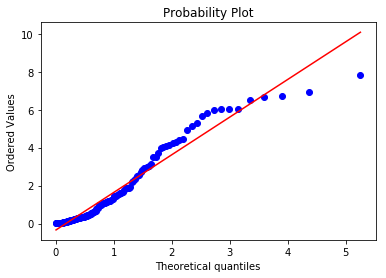



k = 1, size = 3
Number of negative jump times: 63
Mean: 3.22115873015873


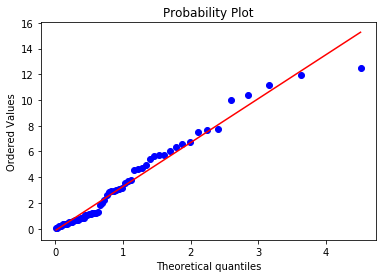



k = 1, size = 4
Number of negative jump times: 42
Mean: 3.856761904761905


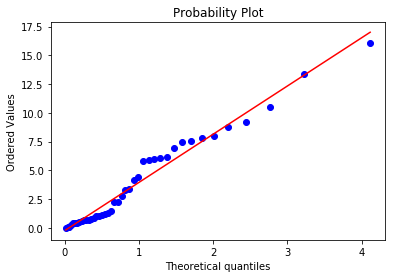



k = 1, size = 5
Number of negative jump times: 58
Mean: 3.1862068965517243


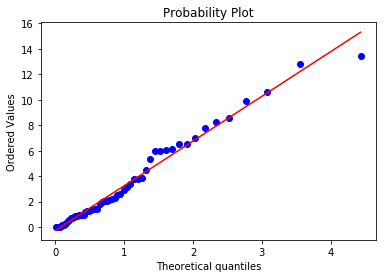



k = 1, size = 6
Number of negative jump times: 55
Mean: 3.947054545454546


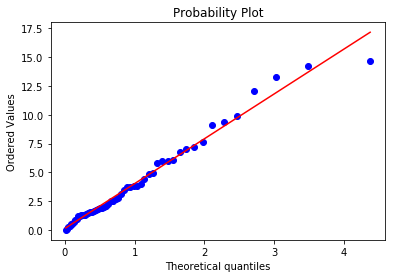



k = 1, size = 7
Number of negative jump times: 81
Mean: 4.042543209876543


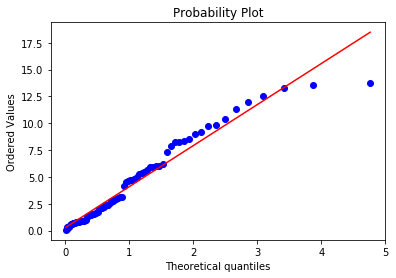



k = 1, size = 8
Number of negative jump times: 50
Mean: 3.09728


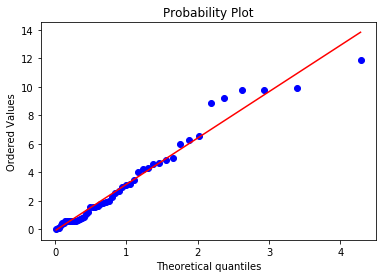



k = 1, size = 9
Number of negative jump times: 26
Mean: 2.6211923076923074


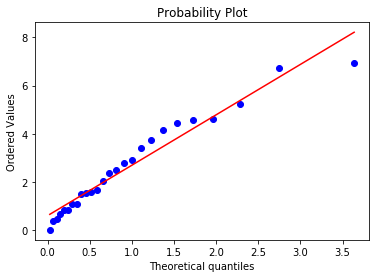



k = 2, size = 1
Number of negative jump times: 34
Mean: 7.144205882352941


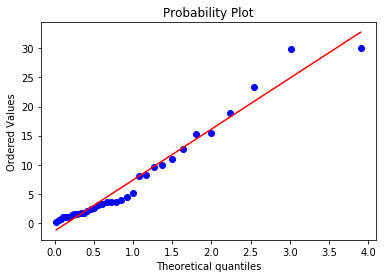



k = 2, size = 2
Number of negative jump times: 53
Mean: 5.937264150943396


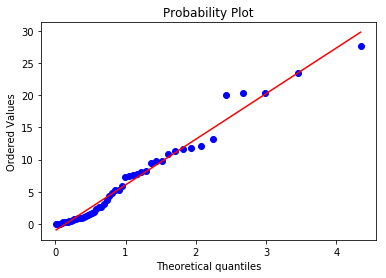



k = 2, size = 3
Number of negative jump times: 138
Mean: 4.700282608695652


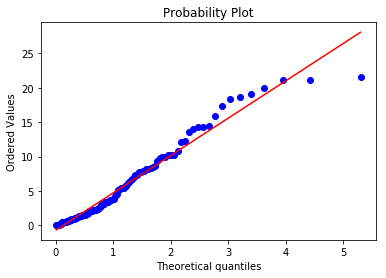



k = 3, size = 1
Number of negative jump times: 101
Mean: 2.595910891089109


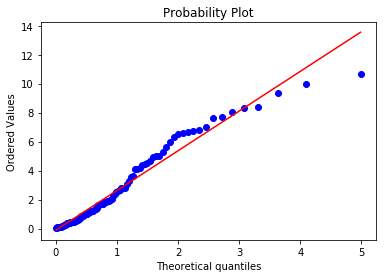



k = 3, size = 2
Number of negative jump times: 192
Mean: 1.6145052083333333


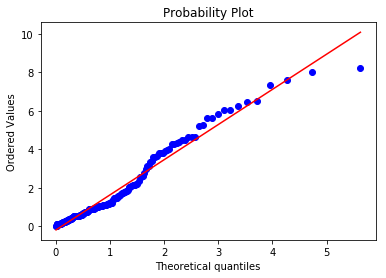



k = 3, size = 12
Number of negative jump times: 104
Mean: 5.201221153846153


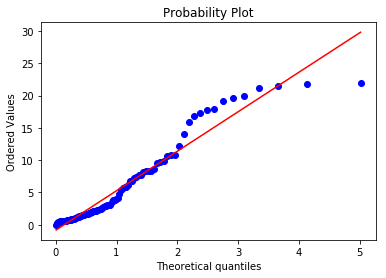



k = 3, size = 13
Number of negative jump times: 57
Mean: 1.9976491228070175


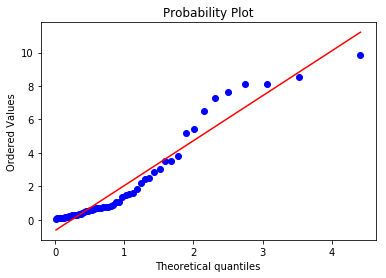



k = 4, size = 1
Number of negative jump times: 98
Mean: 0.8313775510204082


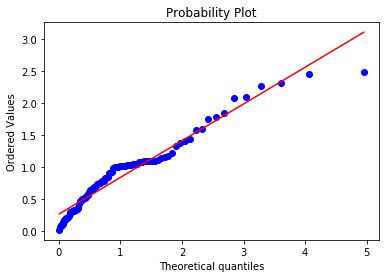



k = 4, size = 2
Number of negative jump times: 99
Mean: 0.9116060606060608


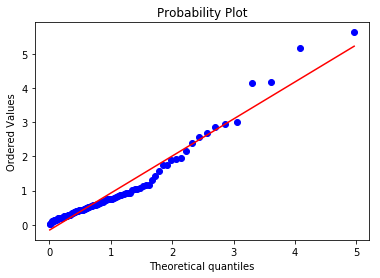



k = 4, size = 3
Number of negative jump times: 62
Mean: 0.6009516129032257


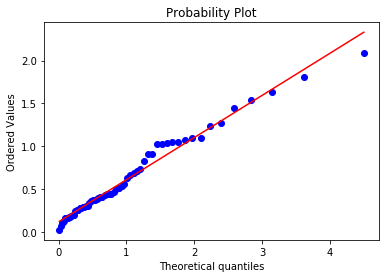



k = 4, size = 12
Number of negative jump times: 100
Mean: 1.1303800000000002


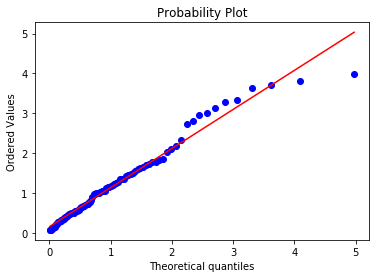



k = 4, size = 13
Number of negative jump times: 57
Mean: 0.5694912280701755


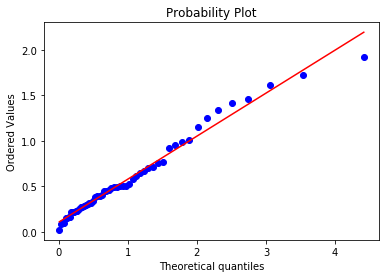



k = 5, size = 1
Number of negative jump times: 65
Mean: 0.6514


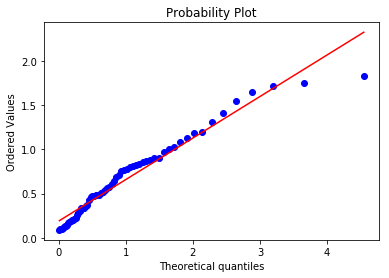



k = 5, size = 2
Number of negative jump times: 25
Mean: 0.39683999999999997


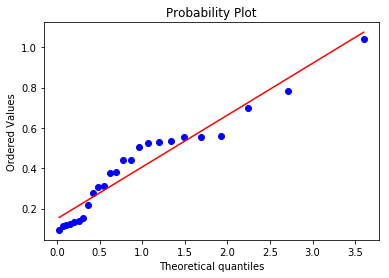



k = 5, size = 10
Number of negative jump times: 39
Mean: 0.4161282051282051


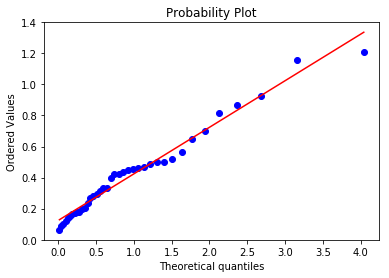

In [177]:
# Remove outliers
def without_outliers(data):
    if len(data) <= 3:
        return data
    quartiles = np.percentile(data,[25,50,75])
    IQR = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - 2*IQR
    upper_bound = quartiles[2] + 2*IQR
    return [d for d in data if d >= lower_bound and d <= upper_bound]

for k in time_between_events_pos:
    time_between_events_pos[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_pos[k].items()])
    time_between_events_pos[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_pos[k].items() if len(ts) > 20])
# time_between_events_pos = OrderedDict([(k,d) for (k,d) in time_between_events_pos.items() if len(d) > 0])
        
for k in time_between_events_neg:
    time_between_events_neg[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_neg[k].items()])
    time_between_events_neg[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_neg[k].items() if len(ts) > 20])    
# time_between_events_neg = OrderedDict([(k,d) for (k,d) in time_between_events_neg.items() if len(d) > 0])

       
for k,v in time_between_events_pos.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of positive jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

for k,v in time_between_events_neg.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of negative jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

# Compare to aribrtary exponential distribution

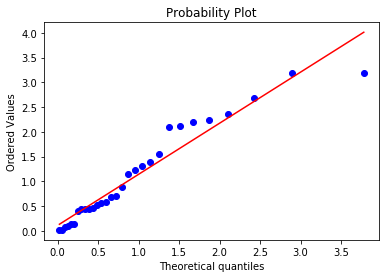

In [178]:
x = [np.random.exponential() for _ in range(30)]
kstest(x,'expon',args=(np.mean(x),))
probplot(x, dist=expon, plot=pylab)
pylab.show()

# Graph Arrival Rates

-10


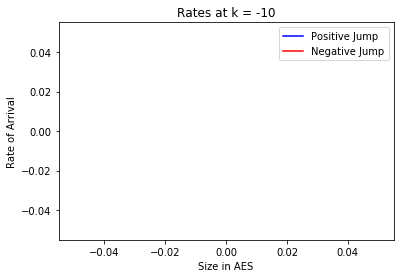

-9


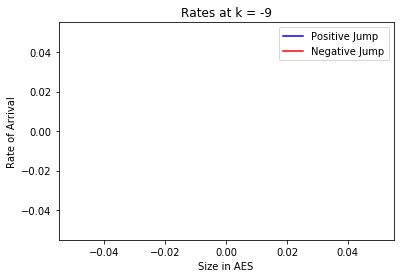

-8


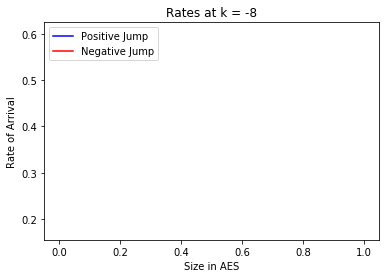

-7


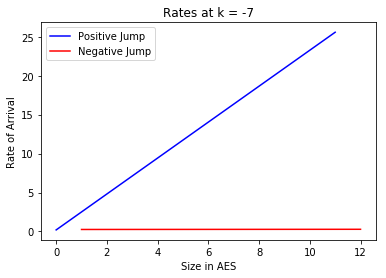

-6


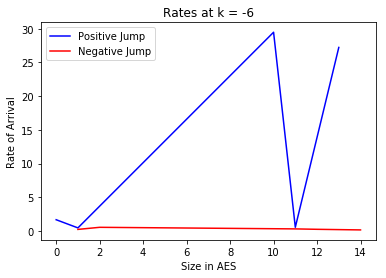

-5


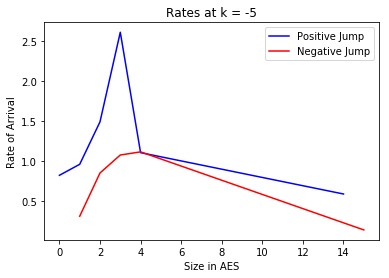

-4


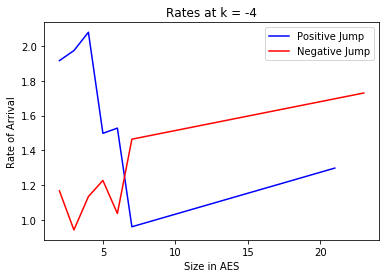

-3


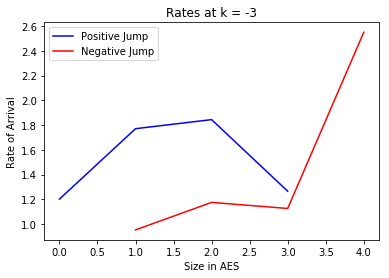

-2


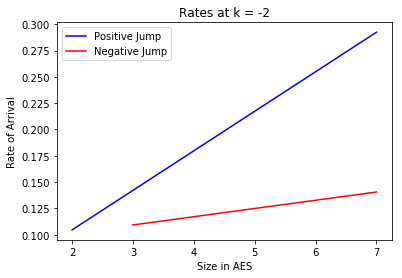

-1


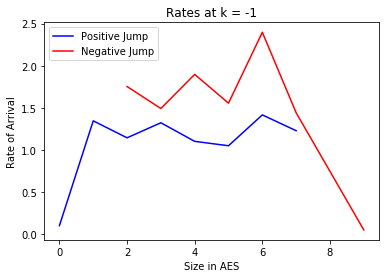

1


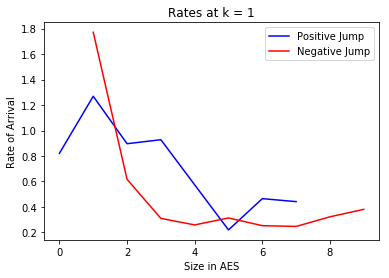

2


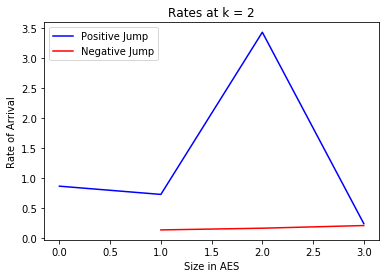

3


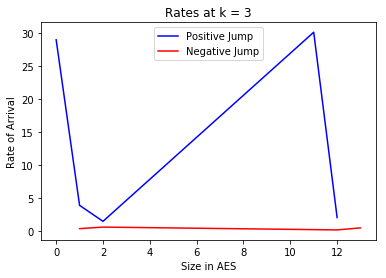

4


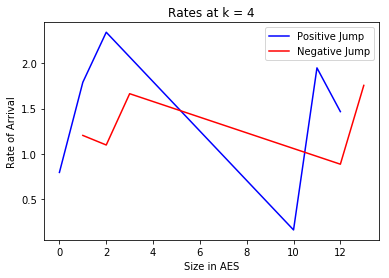

5


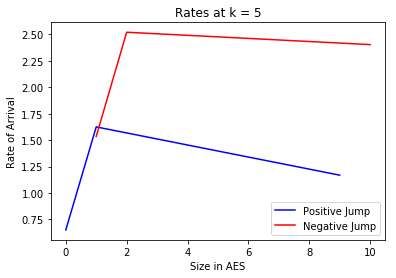

6


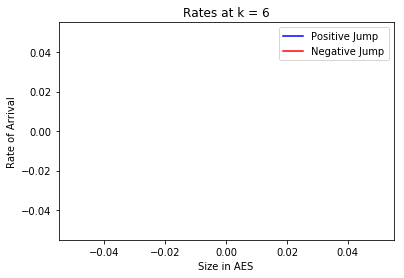

7


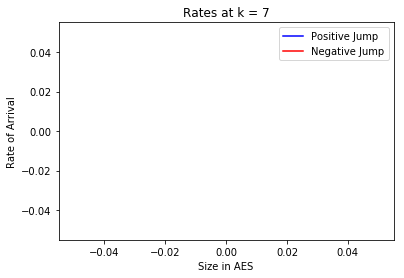

8


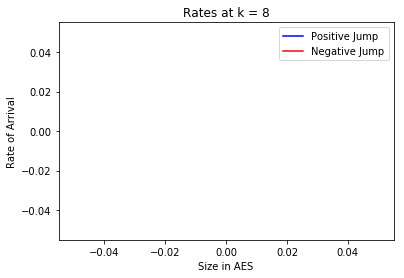

9


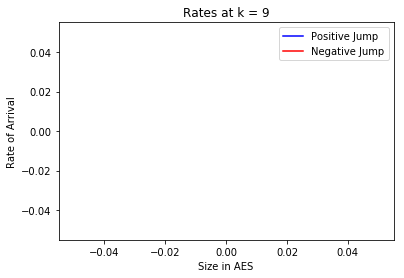

10


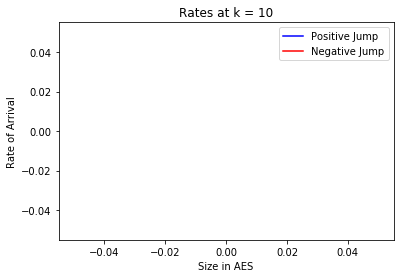

In [184]:
pos_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_pos])
neg_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_neg])

for k in pos_rates_dict:
    pos_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_pos[k].items()])
for k in neg_rates_dict:
    neg_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_neg[k].items()])

for k in range(-K,K+1):
    if k == 0:
        continue
    
    print(k)
        
    if len(pos_rates_dict[k]) > 0:
        pos_size,pos_rates = zip(*(pos_rates_dict[k].items()))
    else:
        pos_size,pos_rates = [],[]
        
    if len(neg_rates_dict[k]) > 0:
        neg_size,neg_rates = zip(*(neg_rates_dict[k].items()))
    else:
        neg_size,neg_rates = [],[]
        
    plt.plot(pos_size,pos_rates,'b')
    plt.plot(neg_size,neg_rates,'r')
    plt.xlabel('Size in AES')
    plt.ylabel('Rate of Arrival')
    plt.title('Rates at k = {}'.format(k))
    plt.legend(['Positive Jump', 'Negative Jump'])
    plt.show()
        
        